In [1]:
%matplotlib inline
import numpy
import matplotlib
import matplotlib.pyplot as plt
import os
import sys

In [2]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('colorblind')

In [23]:
from imp import reload
import read_annotations
reload(read_annotations);

In [4]:
ANNOTATIONS_DIR = '/home/mteruel/am/data/echr/annotation/originals/'
ANNOTATORS = {
    'M': {'dirname': 'M'},
#     'L': {'dirname': 'L'},
#     'S': {'dirname': 'S'},
    'C': {'dirname': 'C'},
    'F': {'dirname': 'F'}
}

### Find files to compare

Find pairs of files annotated for more than one annotator.

In [24]:
document_pairs, all_files = read_annotations.get_annotated_documents(ANNOTATIONS_DIR, ANNOTATORS)
document_pairs, all_files

([(Case: ALKASI v. TURKEY - Ann: M, Case: ALKASI v. TURKEY - Ann: C),
  (Case: ALKASI v. TURKEY - Ann: M, Case: ALKASI v. TURKEY - Ann: F),
  (Case: ALKASI v. TURKEY - Ann: C, Case: ALKASI v. TURKEY - Ann: F),
  (Case: BARCZA AND OTHERS v HUNGARY - Ann: M,
   Case: BARCZA AND OTHERS v HUNGARY - Ann: F),
  (Case: TALMANE v. LATVIA - Ann: M, Case: TALMANE v. LATVIA - Ann: C)],
 [{'C': Case: ALKASI v. TURKEY - Ann: C,
   'F': Case: ALKASI v. TURKEY - Ann: F,
   'M': Case: ALKASI v. TURKEY - Ann: M},
  {'F': Case: BARCZA AND OTHERS v HUNGARY - Ann: F,
   'M': Case: BARCZA AND OTHERS v HUNGARY - Ann: M},
  {'C': Case: TALMANE v. LATVIA - Ann: C,
   'M': Case: TALMANE v. LATVIA - Ann: M}])

In [25]:
STYLES = {'claim': 'red', 'premise': 'green', 'major-claim': 'blue'}

In [32]:
def get_file(index, annotator='M'):
    return list([x for x in all_files])[index][annotator]
get_file(0)

Case: ALKASI v. TURKEY - Ann: M

In [33]:
# TODO This is not showing the boundaries of the annotation as they are in the .ann files
print(get_file(index=0, annotator='M').sample_labeled_text(50, STYLES))

18 . Relying on {Article 6 of the Convention }, the applicant complains that {the labour court ’ s dismissal of her claim for compensation against her former employer amounted to a violation of her right to be presumed innocent }, in that {the labour court found that she had broken her employer ’ s trust by committing the offence of incitement }. 

The applicant argues that {the labour court ’ s complete disregard of her acquittal in relation to the charge of incitement is incompatible with the requirements of Article 6 § 2 of the Convention }. 

She further claims that {the Bakırköy Labour Court based its decision on self-incriminating statements which she had given to the police in the absence of her lawyer }. 

19 . Being the master of the characterisation to be given in law to the facts of the case , the Court considers that {the applicant ’ s grievances fall to be examined solely under Article 6 § 2 of the Convention }which reads as follows : 

“ {Everyone charged with a criminal 

# Inter annotator agreement

In [47]:
import show_metrics
reload(show_metrics);

## Sentence level comparison

We compare the agreement on classifying argumentative vs non argumentative sentences

Kohen-'s Kappa Ann: M - Ann: C: 0.8440779610194903
Observed Agreement: 92.31%


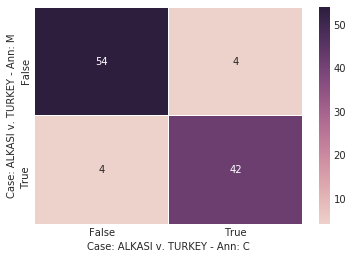

Kohen-'s Kappa Ann: M - Ann: F: 0.8650852483320979
Observed Agreement: 93.27%


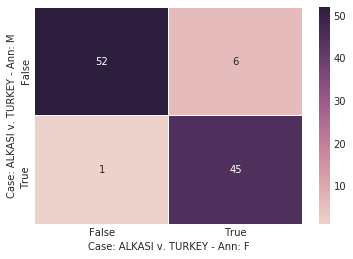

Kohen-'s Kappa Ann: C - Ann: F: 0.8650852483320979
Observed Agreement: 93.27%


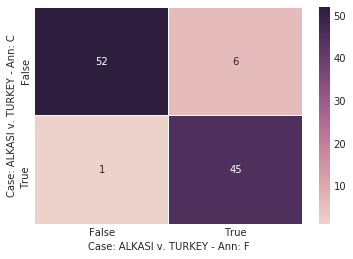

Kohen-'s Kappa Ann: M - Ann: F: 0.8138015516537362
Observed Agreement: 90.64%


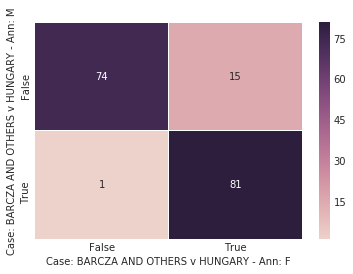

Kohen-'s Kappa Ann: M - Ann: C: 0.6961787429525996
Observed Agreement: 84.54%


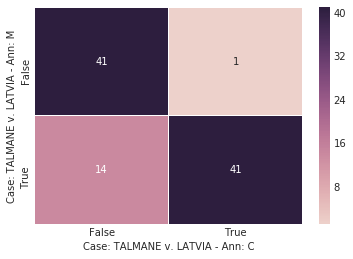

In [35]:
def get_argumentative_sentences(document):
    return [sentence.has_label for sentence in document.sentences]

for doc1, doc2 in document_pairs:
    labels1 = get_argumentative_sentences(doc1)
    labels2 = get_argumentative_sentences(doc2)
    show_metrics.show_kappa(labels1, labels2, doc1.identifier, doc2.identifier)
    show_metrics.show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

In [57]:
kalphas = []
fkappas = []
for document in all_files:
    print(list(document.values())[0].identifier.split('-')[0].strip())  # Print doc title
    labels = [get_argumentative_sentences(annotator) for annotator in document.values()]
    kalphas.append(show_metrics.show_krippendorff_alpha(labels))
    fkappas.append(show_metrics.show_fleiss_kappa(labels))
print('Mean Krippendorff Alpha: {0:.3f}'.format(numpy.mean(kalphas)))
print('Mean Fleiss Kappa: {0:.3f}'.format(numpy.mean(fkappas)))

Case: ALKASI v. TURKEY
Krippendorff Alpha: 0.858
Fleiss Kappa: -0.008
Case: BARCZA AND OTHERS v HUNGARY
Krippendorff Alpha: 0.813
Fleiss Kappa: 0.001
Case: TALMANE v. LATVIA
Krippendorff Alpha: 0.692
Fleiss Kappa: 0.008
Mean Krippendorff Alpha: 0.788
Mean Fleiss Kappa: 0.000


----
## Token level comparison

### Identification

Kappa agreement using labels `Args` vs `Non-Arg`.

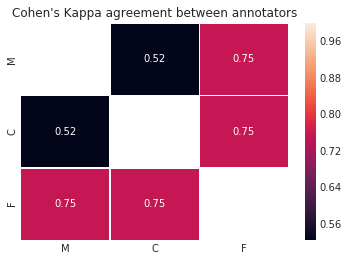

In [36]:
def get_argumentative_words(labels):
    return ['Arg' if x != 'O' else 'O' for x in labels]

show_metrics.show_general_agreement(document_pairs, process_function=get_argumentative_words,
                                    annotators=len(ANNOTATORS))

Kohen-'s Kappa Ann: M - Ann: C: 0.7597460686665967
Observed Agreement: 88.01%


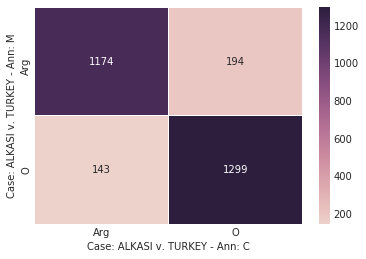

Kohen-'s Kappa Ann: M - Ann: F: 0.7199425528361005
Observed Agreement: 85.94%


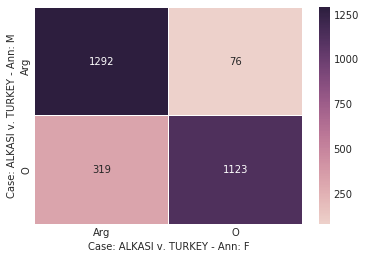

Kohen-'s Kappa Ann: C - Ann: F: 0.7531565095652794
Observed Agreement: 87.54%


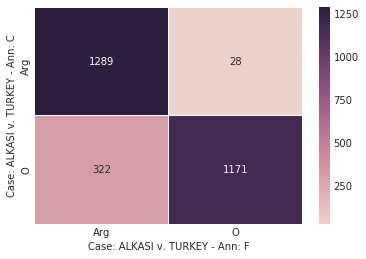

Kohen-'s Kappa Ann: M - Ann: F: 0.7538485981870258
Observed Agreement: 87.66%


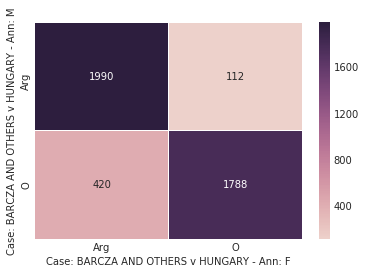

Kohen-'s Kappa Ann: M - Ann: C: 0.5228794435328996
Observed Agreement: 75.56%


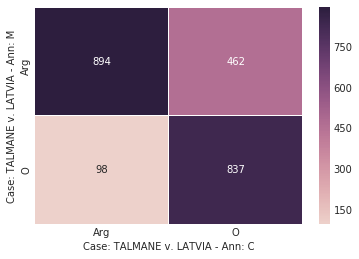

In [37]:
for doc1, doc2 in document_pairs:
    labels1, labels2 = read_annotations.get_labels(doc1, doc2)
    labels1 = get_argumentative_words(labels1)
    labels2 = get_argumentative_words(labels2)
    show_metrics.show_kappa(labels1, labels2, doc1.identifier, doc2.identifier)
    show_metrics.show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

In [58]:
kalphas = []
fkappas = []
for document in all_files:
    print(list(document.values())[0].identifier.split('-')[0].strip())  # Print doc title
    labels = [get_argumentative_words(annotator.get_word_label_list()[1]) for annotator in document.values()]
    kalphas.append(show_metrics.show_krippendorff_alpha(labels))
    fkappas.append(show_metrics.show_fleiss_kappa(labels))
print('Mean Krippendorff Alpha: {0:.3f}'.format(numpy.mean(kalphas)))
print('Mean Fleiss Kappa: {0:.3f}'.format(numpy.mean(fkappas)))

Case: ALKASI v. TURKEY
Krippendorff Alpha: 0.743
Fleiss Kappa: 0.008
Case: BARCZA AND OTHERS v HUNGARY
Krippendorff Alpha: 0.753
Fleiss Kappa: 0.005
Case: TALMANE v. LATVIA
Krippendorff Alpha: 0.511
Fleiss Kappa: 0.025
Mean Krippendorff Alpha: 0.669
Mean Fleiss Kappa: 0.013


----
## Classification

Kappa agreement using only labels `claim` and `premise`

In [54]:
kalphas = []
fkappas = []
for document in all_files:
    print(list(document.values())[0].identifier.split('-')[0].strip())  # Print doc title
    kalphas.append(show_metrics.show_krippendorff_alpha(
        [annotator.get_word_label_list()[1] for annotator in document.values()]))
    fkappas.append(show_metrics.show_fleiss_kappa(
        [annotator.get_word_label_list()[1] for annotator in document.values()]))
print('Mean Krippendorff Alpha: {0:.3f}'.format(numpy.mean(kalphas)))
print('Mean Fleiss Kappa: {0:.3f}'.format(numpy.mean(fkappas)))

Case: ALKASI v. TURKEY
Krippendorff Alpha: 0.685
Fleiss Kappa: 0.013
Case: BARCZA AND OTHERS v HUNGARY
Krippendorff Alpha: 0.674
Fleiss Kappa: 0.018
Case: TALMANE v. LATVIA
Krippendorff Alpha: 0.470
Fleiss Kappa: 0.023
Mean Krippendorff Alpha: 0.610
Mean Fleiss Kappa: 0.018


In [51]:
doc = list(all_files[0].values())[0]
doc

'Case: ALKASI v. TURKEY - Ann: M'

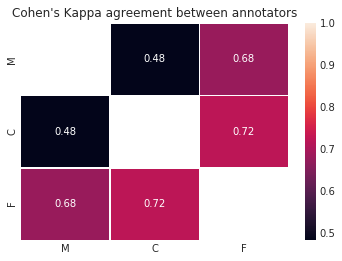

In [42]:
show_metrics.show_general_agreement(document_pairs, annotators=len(ANNOTATORS))

Kohen-'s Kappa Ann: M - Ann: C: 0.6885410880657379
Observed Agreement: 81.21%


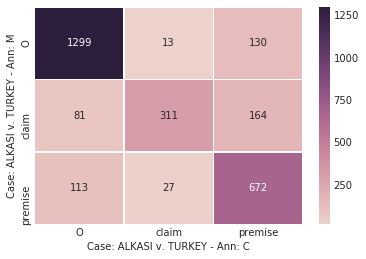

Kohen-'s Kappa Ann: M - Ann: F: 0.6522503671175881
Observed Agreement: 78.22%


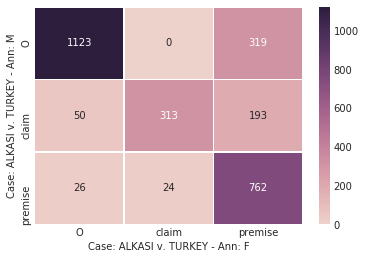

Kohen-'s Kappa Ann: C - Ann: F: 0.7217776163322347
Observed Agreement: 83.24%


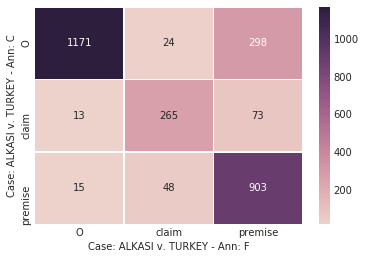

Kohen-'s Kappa Ann: M - Ann: F: 0.6796495537746672
Observed Agreement: 79.58%


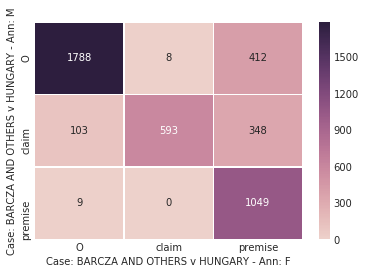

Kohen-'s Kappa Ann: M - Ann: C: 0.4825468622173743
Observed Agreement: 66.74%


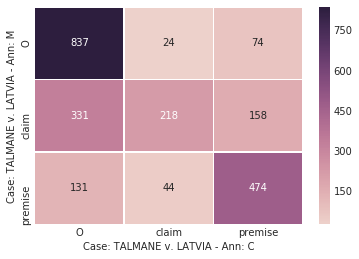

In [43]:
for doc1, doc2 in document_pairs:
    labels1, labels2 = read_annotations.get_labels(doc1, doc2)
    show_metrics.show_kappa(labels1, labels2, doc1.identifier, doc2.identifier)
    show_metrics.show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

### Attribute analysis

Kohen-'s Kappa Ann: M - Ann: C: 0.5801387076980957
Observed Agreement: 72.68%


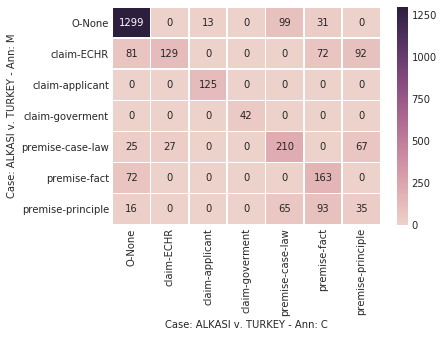

Kohen-'s Kappa Ann: M - Ann: F: 0.5861036991800804
Observed Agreement: 69.86%


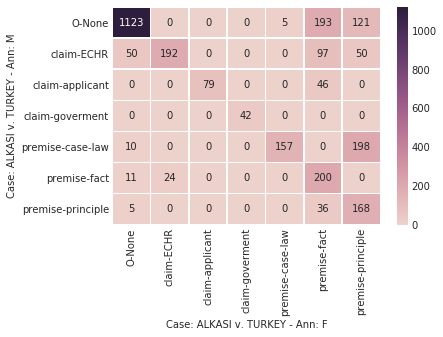

Kohen-'s Kappa Ann: C - Ann: F: 0.550557018585331
Observed Agreement: 67.62%


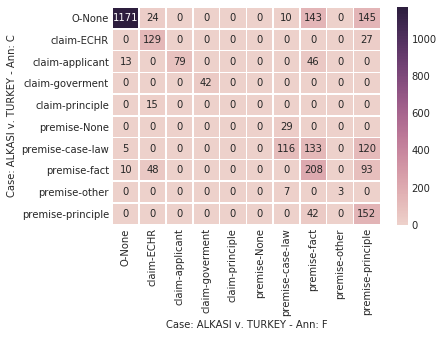

Kohen-'s Kappa Ann: M - Ann: F: 0.667104224523787
Observed Agreement: 76.79%


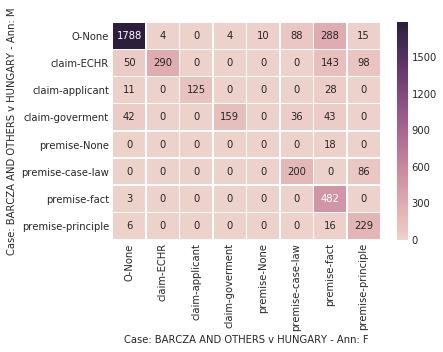

Kohen-'s Kappa Ann: M - Ann: C: 0.4789492719472247
Observed Agreement: 62.83%


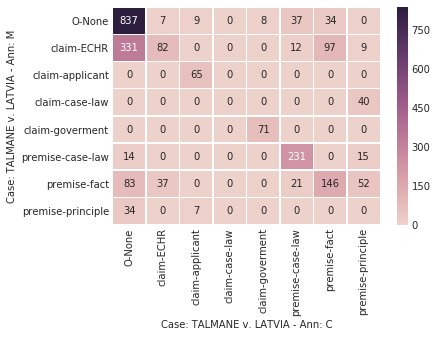

In [59]:
def get_labels_with_attributes(document):
    result = []
    for sentence in document.sentences:
        for label, attribute in zip(sentence.labels, sentence.attributes):
            if attribute is not None:
                attribute = attribute[1]
            result.append('{}-{}'.format(label, attribute))
    return result

for doc1, doc2 in document_pairs:
    labels1, labels2 = get_labels_with_attributes(doc1), get_labels_with_attributes(doc2)
    show_metrics.show_kappa(labels1, labels2, doc1.identifier, doc2.identifier)
    show_metrics.show_confusion_matrix(labels1, labels2, doc1.identifier, doc2.identifier)

## Qualitative error analysis

In [60]:
def sample_sentences(doc1, doc2, label1, label2, tolerance=0):
    """Samples sentences where label1 was confused with label2 in
    doc1 and doc2 respectively.
    """
    total_errors = 0
    for sentence1, sentence2 in zip(doc1.sentences, doc2.sentences):
        indices1 = [i for i, x in enumerate(sentence1.labels) if x == label1]
        if len(indices1) == 0:
            continue
        indices2 = [i for i, x in enumerate(sentence2.labels) if x == label2]
        if len(indices2) == 0 or len(set(indices1).intersection(indices2)) < tolerance:
            continue
        total_errors += len(set(indices1).intersection(indices2))
        # Print both sentences
        print(sentence1.pretty_print(styles=STYLES))
        print(sentence2.pretty_print(styles=STYLES))
        print('---')
    print('TOTAL ERRORS:', total_errors)

Examples labeled as `premise` in one document and as `O` in the other

In [61]:
[(index, document_pair) for index, document_pair in enumerate(document_pairs)]

[(0, (Case: ALKASI v. TURKEY - Ann: M, Case: ALKASI v. TURKEY - Ann: C)),
 (1, (Case: ALKASI v. TURKEY - Ann: M, Case: ALKASI v. TURKEY - Ann: F)),
 (2, (Case: ALKASI v. TURKEY - Ann: C, Case: ALKASI v. TURKEY - Ann: F)),
 (3,
  (Case: BARCZA AND OTHERS v HUNGARY - Ann: M,
   Case: BARCZA AND OTHERS v HUNGARY - Ann: F)),
 (4, (Case: TALMANE v. LATVIA - Ann: M, Case: TALMANE v. LATVIA - Ann: C))]

How to use? Select the pair of annotators that you want to compare using the index shown in the previous cell. Then, select the type of component

In [62]:
pair_to_see = 0
component_annotator_1 = 'premise'
component_annotator_2 = 'O'
sample_sentences(document_pairs[pair_to_see][0], document_pairs[pair_to_see][1],
                 component_annotator_1, component_annotator_2, tolerance=2)

18 . Relying on {Article 6 of the Convention }, the applicant complains that {the labour court ’ s dismissal of her claim for compensation against her former employer amounted to a violation of her right to be presumed innocent }, in that {the labour court found that she had broken her employer ’ s trust by committing the offence of incitement }. 
18 . Relying on Article 6 of the Convention , the applicant complains that {the labour court ’ s dismissal of her claim for compensation against her former employer amounted to a violation of her right to be presumed innocent }, in that {the labour court found that she had broken her employer ’ s trust by committing the offence of incitement }. 
---
Although {she had retracted her statements at a later date and denied having committed the alleged offence }, {the labour court had established that the acts of the applicant had breached her employer ’ s trust and therefore justified her dismissal from her post }. 
Although {she had retracted her